# Trust but Verify - Inspection of Large Image Collections

This notebook and accompanying [Python script characterize_data.py](characterize_data.py) illustrate the use of SimpleITK as a tool for efficient data inspection on large image collections, as part of familiarizing oneself with the data and performing cleanup prior to its use in deep learning or any other supervised machine learning approach.

The reasons for inspecting your data before using it include:
1. Identification of corrupt images.
2. Identification of erroneous images (label noise).
3. Assessment of data quality and variability in terms of intensity range, image resolution, and pixel types.
4. Reduction of workload, identifying redundant information content (e.g. a greyscale/single channel image masquerading as a color/three channel image - think x-ray in jpg file).


We inspect our data in two ways:
1. Summary of image characteristics found in a directory structure (generic and DICOM specific).
2. Visual inspection of the image content.

SimpleITK allows us to easily control for the image types we are interested in via the ImageIO. The currently supported/registered IO types are defined by the following strings:
* 'BMPImageIO'
* 'BioRadImageIO'
* 'Bruker2dseqImageIO'
* 'GDCMImageIO'
* 'GE4ImageIO'
* 'GE5ImageIO'
* 'GiplImageIO'
* 'HDF5ImageIO'
* 'JPEGImageIO'
* 'JPEG2000ImageIO'
* 'LSMImageIO'
* 'MINCImageIO'
* 'MRCImageIO'
* 'MetaImageIO'
* 'NiftiImageIO'
* 'NrrdImageIO'
* 'PNGImageIO'
* 'StimulateImageIO'
* 'TIFFImageIO'
* 'VTKImageIO'
* '' - empty string denotes all image file formats.

To see the set of ImageIO types supported by your version of SimpleITK, call [ImageFileReader::GetRegisteredImageIOs()](https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1ImageReaderBase.html#a4cbb7db3eb3796eee8d89a1aaf011511) or simply print an ImageFileReader object.

In [1]:
import SimpleITK as sitk
import pandas as pd
import numpy as np
import os
import sys
import shutil
import subprocess
import multiprocessing
from functools import partial

# We use the multiprocess package instead of the official
# multiprocessing as it currently has several issues as discussed
# on the software carpentry page: https://hpc-carpentry.github.io/hpc-python/06-parallel/
import multiprocess as mp
import platform

import hashlib
import tempfile
import pickle


import matplotlib.pyplot as plt
import ipywidgets as widgets
import ipympl


# utility method that either downloads data from the Girder repository or
# if already downloaded returns the file name for reading from disk (cached data)
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

OUTPUT_DIR = "Output"

# Maximal number of parallel processes we run.
MAX_PROCESSES = 5

In [2]:
%env SITK_SHOW_COMMAND /Applications/Slicer.app/Contents/MacOS/Slicer

env: SITK_SHOW_COMMAND=/Applications/Slicer.app/Contents/MacOS/Slicer


In [3]:
%matplotlib widget

In [4]:
data_root_dir = "../Data"

In [9]:
!ls ../Data

2th_cthead1.png                      cthead1.png
B1.tiff                              fib_sem_bacillus_subtilis.mha
B1_fixed_B2_moving0GenericAffine.mat head_mr_oriented.mha
B1_fixed_B2_movingComposite.h5       liverTumorSegmentations
B2.tiff                              manifest.json
CIRS057A_MR_CT_DICOM                 min_manifest.json
Control.tif                          mr_slice_atlas
POPI                                 nac-hncma-atlas2013-Slicer4Version
SimpleITK.jpg                        spherical_fiducials.mha
VM1111Shrink-RGB.png                 training_001_ct.mha
a_vm1108.png                         training_001_mr_T1.mha
brains_manifest.json                 vm_head_mri.mha
coins.png                            vm_head_rgb.mha
ct_T1.standard


In [8]:
!ls ../Data/CIRS057A_MR_CT_DICOM

1.dcm      19-137.dcm 19-265.dcm 19-76.dcm  22-173.dcm 22-300.dcm 232.dcm
10.dcm     19-138.dcm 19-266.dcm 19-77.dcm  22-174.dcm 22-301.dcm 233.dcm
100.dcm    19-139.dcm 19-267.dcm 19-78.dcm  22-175.dcm 22-302.dcm 234.dcm
101.dcm    19-14.dcm  19-268.dcm 19-79.dcm  22-176.dcm 22-303.dcm 235.dcm
102.dcm    19-140.dcm 19-269.dcm 19-8.dcm   22-177.dcm 22-304.dcm 236.dcm
103.dcm    19-141.dcm 19-27.dcm  19-80.dcm  22-178.dcm 22-305.dcm 237.dcm
104.dcm    19-142.dcm 19-270.dcm 19-81.dcm  22-179.dcm 22-306.dcm 238.dcm
105.dcm    19-143.dcm 19-271.dcm 19-82.dcm  22-18.dcm  22-307.dcm 239.dcm
106.dcm    19-144.dcm 19-272.dcm 19-83.dcm  22-180.dcm 22-308.dcm 24.dcm
107.dcm    19-145.dcm 19-273.dcm 19-84.dcm  22-181.dcm 22-309.dcm 240.dcm
108.dcm    19-146.dcm 19-274.dcm 19-85.dcm  22-182.dcm 22-31.dcm  241.dcm
109.dcm    19-147.dcm 19-275.dcm 19-86.dcm  22-183.dcm 22-310.dcm 242.dcm
11.dcm     19-148.dcm 19-276.dcm 19-87.dcm  22-184.dcm 22-311.dcm 243.dcm
110.dcm    19-149.dcm 19-277.dcm 19-88.

In [7]:
!cat ../Data/CIRS057A_MR_CT_DICOM/readme.txt

This directory contains a CT and MR scan of the CIRS 057A multi-modality 
abdominal phantom.

NOTE: There are fiducials on the phantom, both in the CT and MR - THEY ARE NOT
      THE SAME FIDUCIALS. The scans were acquired at different times.


In [23]:
img = sitk.ReadImage("../Data/CIRS057A_MR_CT_DICOM/230.dcm")

In [24]:
type(img)

SimpleITK.SimpleITK.Image

In [27]:
for key in img.GetMetaDataKeys():
    print(f'"{key}":"{img.GetMetaData(key)}"')

"0008|0000":"600"
"0008|0005":"ISO_IR 100"
"0008|0008":"ORIGINAL\PRIMARY\AXIAL"
"0008|0012":"20140502"
"0008|0013":"131043"
"0008|0016":"1.2.840.10008.5.1.4.1.1.2"
"0008|0018":"1.2.840.113619.2.290.3.3233817346.783.1399004564.799.255"
"0008|0020":"20140502"
"0008|0021":"20140502"
"0008|0022":"20140502"
"0008|0023":"20140502"
"0008|0030":"130856"
"0008|0031":"131001"
"0008|0032":"131020.862165 "
"0008|0033":"131043"
"0008|0050":""
"0008|0060":"CT"
"0008|0070":"GE MEDICAL SYSTEMS"
"0008|0080":"Childrens National Medical Ctr"
"0008|0090":""
"0008|1010":"ct83"
"0008|1030":""
"0008|103e":"ABDOMEN "
"0008|1050":""
"0008|1060":""
"0008|1070":""
"0008|1090":"Discovery 690 "
"0010|0000":"78"
"0010|0010":"test"
"0010|0020":"0000000000000 "
"0010|0030":""
"0010|0040":""
"0010|1000":""
"0010|1010":"000Y"
"0010|21b0":""
"0018|0000":"446"
"0018|0022":"HELICAL MODE"
"0018|0050":"0.625000"
"0018|0060":"120 "
"0018|0088":"0.625000"
"0018|0090":"500.000000"
"0018|1020":"pet_mict_plus.44"
"0018|1030":"16

TypeError: Invalid shape (1, 512, 512) for image data

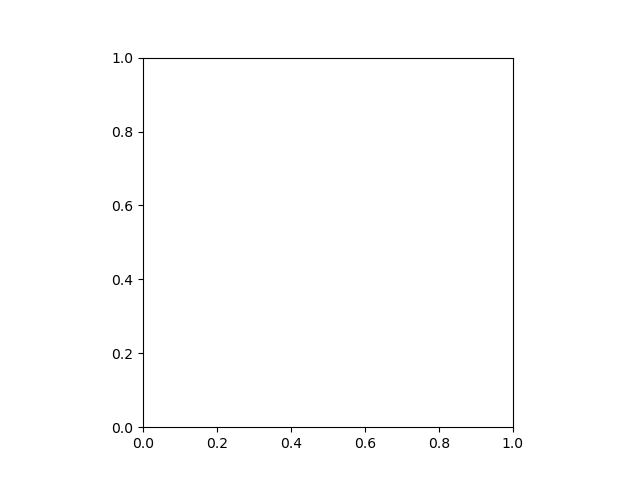

In [28]:
plt.imshow(sitk.GetArrayViewFromImage(img)) #error
plt.axis("off");

## Data

For convenience, we use the heterogeneous notebook data. This dataset includes both 2D and 3D images, color and greyscale and 3D images stored as a set of 2D slices (DICOM series). Before starting down this path, make sure you have downloaded all notebook data. Downloading the data is described in the [setup notebook](00_Setup.ipynb). 


Generally speaking, in the context of deep learning most datasets will be larger and more homogeneous. A nicely sized dataset that is "just right" in terms of download time, yet is large enough to illustrate the utility of data inspection, more than 7000 images, is the OpenI Indiana chest x-ray dataset (+100GB of DICOM images in a [single tgz file](https://openi.nlm.nih.gov/imgs/collections/NLMCXR_dcm.tgz)). 

The publication describing the dataset is: D. Demner-Fushman et. al., "Preparing a collection of radiology examinations for distribution and retrieval", J Am Med Inform Assoc., 23(2):304-310, 2016.

Using the Indiana dataset, see how long it takes you to identify several images that should have not been included. See if you could identify them only using the textual based csv summary report file.

## Characterizing  image set

To characterize the image set we have written a [Python script](characterize_data.py) that you should run from the command line. This script is very flexible and allows you to robustly characterize your image set. Try the various options and learn more about your data. You'd be surprised how many times the data isn't what you thought it is when only relying on visual inspection. The script allows you to inspect your data both on a file by file basis and as DICOM series where an image (volume) is stored in multiple files.

File by file:
```
python characterize_data.py data output/generic_image_data_report.csv per_file \
--imageIO "" --external_applications ./dciodvfy --external_applications_headings "DICOM Compliant" \
--metadata_keys "0008|0060" "0018|5101" --metadata_keys_headings "modality" "radiographic view"
```

DICOM series:
```
python characterize_data.py data output/DICOM_image_data_report.csv per_series \
--metadata_keys "0008|0060" "0018|5101" --metadata_keys_headings "modality" "radiographic view"  
```


After characterizing the image set we turn to visual inspection. 

In [ ]:
!rm output/*.csv
!ls output/*.csv

In [ ]:
!python characterize_data.py --metadata_keys "0008|0060" "0018|5101" --metadata_keys_headings "modality" "radiographic view" 

In [ ]:
!ls -l Output/*.csv

## Visual inspection of  image set

While the reports generated above provide us with many insights with respect to the image content they are not sufficient for identifying erroneous images included in the dataset. For example if we expect our data to contain only frontal, AP or PA, chest x-rays (CXRs) you often also find lateral CXRs in the mix. In theory this would be indicated via the radiographic view DICOM tag. Unfortunately, the tag does not always have the correct value, and when images are converted from DICOM to some other format this information is often lost.

We therefore resort to visual inspection. There's nothing like a human to quickly scan an image collection and identify outliers.

In [ ]:
def process_image(img, projection_axis, thumbnail_size):
    """
    Create a grayscale thumbnail image from the given image. If the image is 3D it is
    projected to 2D using a Maximum Intensity Projection (MIP) approach. Color images
    are converted to grayscale, and high dynamic range images are window leveled using
    a robust approach.

    Parameters
    ----------
    img (SimpleITK.Image): A 2D or 3D grayscale or sRGB image.
    projection_axis(int in [0,2]): The axis along which we project 3D images.
    thumbnail_size (list/tuple(int)): The 2D sizes of the thumbnail.

    Returns
    -------
    2D SimpleITK image with sitkUInt8 pixel type.

    """
    if (
        img.GetDimension() == 3 and img.GetSize()[2] == 1
    ):  # 2D image masquerading as 3D image
        img = img[:, :, 0]
    elif img.GetDimension() == 3:  # 3D image projected along projection_axis direction
        img = sitk.MaximumProjection(img, projection_axis)
        slc = list(img.GetSize())
        slc[projection_axis] = 0
        img = sitk.Extract(img, slc)
    if img.GetNumberOfComponentsPerPixel() == 3:  # sRGB image, convert to gray
        # Convert sRGB image to gray scale and rescale results to [0,255]
        channels = [
            sitk.VectorIndexSelectionCast(img, i, sitk.sitkFloat32)
            for i in range(img.GetNumberOfComponentsPerPixel())
        ]
        # linear mapping
        I = (
            1
            / 255.0
            * (0.2126 * channels[0] + 0.7152 * channels[1] + 0.0722 * channels[2])
        )
        # nonlinear gamma correction
        I = (
            I * sitk.Cast(I <= 0.0031308, sitk.sitkFloat32) * 12.92
            + I ** (1 / 2.4) * sitk.Cast(I > 0.0031308, sitk.sitkFloat32) * 1.055
            - 0.055
        )
        img = sitk.Cast(sitk.RescaleIntensity(I), sitk.sitkUInt8)
    else:
        if img.GetPixelID() != sitk.sitkUInt8:
            # To deal with high dynamic range images that also contain outlier intensities
            # we use window-level intensity mapping and set the window:
            # to [max(Q1 - w*IQR, min_intensity), min(Q3 + w*IQR, max_intensity)]
            # IQR = Q3-Q1
            # The bounds which should exclude outliers are defined by the parameter w,
            # where 1.5 is a standard default value (same as used in box and
            # whisker plots to define whisker lengths).
            w = 1.5
            min_val, q1_val, q3_val, max_val = np.percentile(
                sitk.GetArrayViewFromImage(img).flatten(), [0, 25, 75, 100]
            )
            min_max = [
                np.max([(1.0 + w) * q1_val - w * q3_val, min_val]),
                np.min([(1.0 + w) * q3_val - w * q1_val, max_val]),
            ]
            wl_image = sitk.IntensityWindowing(
                img,
                windowMinimum=min_max[0],
                windowMaximum=min_max[1],
                outputMinimum=0.0,
                outputMaximum=255.0,
            )
            img = sitk.Cast(wl_image, sitk.sitkUInt8)
    res = sitk.Resample(
        img,
        size=thumbnail_size,
        transform=sitk.Transform(),
        interpolator=sitk.sitkLinear,
        outputOrigin=img.GetOrigin(),
        outputSpacing=[
            (sz - 1) * spc / (nsz - 1)
            for nsz, sz, spc in zip(thumbnail_size, img.GetSize(), img.GetSpacing())
        ],
        outputDirection=img.GetDirection(),
        defaultPixelValue=0,
        outputPixelType=img.GetPixelID(),
    )
    res.SetOrigin([0, 0])
    res.SetSpacing([1, 1])
    res.SetDirection([1, 0, 0, 1])
    return res


def visualize_single_file(file_name, imageIO, projection_axis, thumbnail_size):
    image_file_name = ""
    image = None
    try:
        reader = sitk.ImageFileReader()
        reader.SetImageIO(imageIO)
        reader.SetFileName(file_name)
        img = reader.Execute()
        image = process_image(img, projection_axis, thumbnail_size)
        image_file_name = file_name
    except:
        pass
    return (image_file_name, image)


def visualize_files(
    root_dir, imageIO="", projection_axis=2, thumbnail_size=[64, 64], tile_size=[20, 20]
):
    """
    This function traverses the directory structure reading all user selected images
    (selction based on the image file format specified by the caller). All images are converted to 2D grayscale
    in [0,255] as follows:
    * Images with three channels are assumed to be in sRGB color space and converted to grayscale.
    * Grayscale images are window-levelled using robust values for the window-level accomodating
    * for outlying intensity values.
    * 3D images are converted to 2D using maximum intensity projection along the user specified projection axis.
    Parameters
    ----------
    root_dir (str): Path to the root of the data directory. Traverse the directory structure
                    and try to read every file as an image using the given imageIO.
    imageIO (str): Name of image IO to use. To see the list of registered image IOs use the
                   ImageFileReader::GetRegisteredImageIOs() or print an ImageFileReader.
                   The empty string indicates to read all file formats supported by SimpleITK.
    projection_axis (int in [0,2]): 3D images are converted to 2D using mean projection along the
                                    specified axis.
    thumbnail_size (2D tuple/list): The size of the 2D image tile used for visualization.
    tile_size (2D tuple/list): Number of tiles to use in x and y.

    Returns
    -------
    tuple(SimpleITK.Image, list): faux_volume comprised of tiles, file_name_list corrosponding
                                  to the image tiles.
                                  The SimpleITK image contains the meta-data 'thumbnail_size' and
                                  'tile_size'.
    """
    image_file_names = []
    faux_volume = None
    images = []

    all_file_names = []
    for dir_name, subdir_names, file_names in os.walk(root_dir):
        all_file_names += [
            os.path.join(os.path.abspath(dir_name), fname) for fname in file_names
        ]
    if platform.system() == "Windows":
        res = map(
            partial(
                visualize_single_file,
                imageIO=imageIO,
                projection_axis=projection_axis,
                thumbnail_size=thumbnail_size,
            ),
            all_file_names,
        )
    else:
        with mp.Pool(processes=MAX_PROCESSES) as pool:
            res = pool.map(
                partial(
                    visualize_single_file,
                    imageIO=imageIO,
                    projection_axis=projection_axis,
                    thumbnail_size=thumbnail_size,
                ),
                all_file_names,
            )
    res = [data for data in res if data[1] is not None]
    if res:
        image_file_names, images = zip(*res)
        if image_file_names:
            faux_volume = create_tile_volume(images, tile_size)
            faux_volume.SetMetaData(
                "thumbnail_size", " ".join([str(v) for v in thumbnail_size])
            )
            faux_volume.SetMetaData("tile_size", " ".join([str(v) for v in tile_size]))
    return (faux_volume, image_file_names)


def create_tile_volume(images, tile_size):
    """
    Create a faux-volume from a list of images. Each slice in the volume
    is constructed from tile_size[0]*tile_size[1] images. The slices are
    then joined to form the faux volume.

    Parameters
    ----------
    images (list(SimpleITK.Image(2D, sitkUInt8))): image list that we tile.
    tile_size (2D tuple/list): Number of tiles to use in x and y.

    Returns
    -------
    SimpleITK.Image(3D, sitkUInt8): Volume comprised of tiled image slices.
                                    Order of tiles matches the order of the input list.
    """
    step_size = tile_size[0] * tile_size[1]
    faux_volume = [
        sitk.Tile(images[i : i + step_size], tile_size, 0)
        for i in range(0, len(images), step_size)
    ]
    # if last tile image is smaller than others, add background content to match the size
    if len(faux_volume) > 1 and (
        faux_volume[-1].GetHeight() != faux_volume[-2].GetHeight()
        or faux_volume[-1].GetWidth() != faux_volume[-2].GetWidth()
    ):
        img = sitk.Image(faux_volume[-2]) * 0
        faux_volume[-1] = sitk.Paste(
            img, faux_volume[-1], faux_volume[-1].GetSize(), [0, 0], [0, 0]
        )
    return sitk.JoinSeries(faux_volume)


def visualize_series(
    root_dir, projection_axis=2, thumbnail_size=[64, 64], tile_size=[20, 20]
):
    """
    This function traverses the directory structure reading all DICOM series (a series can reside
    in multiple directories). All images are converted to 2D grayscale in [0,255] as follows:
    * Images with three channels are assumed to be in sRGB color space and converted to grayscale.
    * Grayscale images are window-levelled using robust values for the window-level accomodating
    * for outlying intensity values.
    * 3D images are converted to 2D using maximum intensity projection along the user specified projection axis.
    Parameters
    ----------
    root_dir (str): Path to the root of the data directory. Traverse the directory structure
                    and try to read every file as an image using the given imageIO.
    projection_axis (int in [0,2]): 3D images are converted to 2D using mean projection along the
                                    specified axis.
    thumbnail_size (2D tuple/list): The size of the 2D image tile used for visualization.
    tile_size (2D tuple/list): Number of tiles to use in x and y.

    Returns
    -------
    tuple(SimpleITK.Image, list): faux_volume comprised of tiles, series_file_name_lists corrosponding
                                  to the image tiles. The series_file_name_lists is a list of lists where
                                  the sublists are DICOM series.
                                  The SimpleITK image contains the meta-data 'thumbnail_size' and
                                  'tile_size'.
    """
    # collect the file names of all series into a dictionary with the key being
    # study:series.
    all_series_files = {}
    reader = sitk.ImageFileReader()
    for dir_name, subdir_names, file_names in os.walk(root_dir):
        sids = sitk.ImageSeriesReader_GetGDCMSeriesIDs(dir_name)
        for (
            sid
        ) in (
            sids
        ):  # Using absolute file names so that the list is valid no matter where the script is run
            file_names = [
                os.path.abspath(fname)
                for fname in sitk.ImageSeriesReader_GetGDCMSeriesFileNames(
                    dir_name, sid
                )
            ]
            reader.SetFileName(file_names[0])
            reader.ReadImageInformation()
            study = reader.GetMetaData("0020|000d")
            key = f"{study}:{sid}"
            if key in all_series_files:
                all_series_files[key].extend(file_names)
            else:
                all_series_files[key] = list(file_names)
    images_and_files = [
        (process_series(series_data, projection_axis, thumbnail_size), series_data[1])
        for series_data in all_series_files.items()
    ]
    images, files = zip(*images_and_files)
    faux_volume = create_tile_volume(images, tile_size)
    faux_volume.SetMetaData(
        "thumbnail_size", " ".join([str(v) for v in thumbnail_size])
    )
    faux_volume.SetMetaData("tile_size", " ".join([str(v) for v in tile_size]))
    return (faux_volume, files)


def process_series(series_data, projection_axis, thumbnail_size):
    reader = sitk.ImageSeriesReader()
    _, sid = series_data[0].split(":")
    file_names = series_data[1]
    # As the files comprising a series with multiple files can reside in
    # separate directories and SimpleITK expects them to be in a single directory
    # we use a tempdir and symbolic links to enable SimpleITK to read the series as
    # a single image.
    with tempfile.TemporaryDirectory() as tmpdirname:
        if platform.system() == "Windows":
            for i, fname in enumerate(file_names):
                shutil.copy(fname, os.path.join(tmpdirname, str(i)))
        else:
            for i, fname in enumerate(file_names):
                os.symlink(fname, os.path.join(tmpdirname, str(i)))
        reader.SetFileNames(
            sitk.ImageSeriesReader_GetGDCMSeriesFileNames(tmpdirname, sid)
        )
        img = reader.Execute()
        return process_image(img, projection_axis, thumbnail_size)

The class in the following cell `ImageSelection` provides a GUI for displaying and interacting with a tiled faux volume. The user can scroll through the faux volume "slices", zoom in, pan, and select images. When the user clicks on an image a user specified action is taken, `selection_func` is invoked with the file name(s) of the associated image. Two useful user functions are provided at the end of the code cell:
* `show_image` - displays the original image at full resolution using an external viewer (both 2D and 3D).
* `rm_image` - for the more confident user, delete the file(s) associated with the selected image (data cleanup).

The recommended usage is with the `show_image` ensuring that the images you selected should truly be deleted and then deleting them.

In [ ]:
class ImageSelection(object):
    def __init__(
        self, tiled_faux_vol, image_files_list, selection_func=None, figure_size=(8, 8)
    ):
        self.tiled_faux_vol = tiled_faux_vol
        self.thumbnail_size = [
            int(v) for v in self.tiled_faux_vol.GetMetaData("thumbnail_size").split()
        ]
        self.tile_size = [
            int(v) for v in self.tiled_faux_vol.GetMetaData("tile_size").split()
        ]
        self.npa = sitk.GetArrayViewFromImage(self.tiled_faux_vol)
        self.point_indexes = []
        self.selected_image_indexes = []
        self.image_files_list = image_files_list
        self.selection_func = selection_func

        ui = self.create_ui()
        display(ui)

        # Create a figure.
        self.fig, self.axes = plt.subplots(1, 1, figsize=figure_size)
        # Connect the mouse button press to the canvas (__call__ method is the invoked callback).
        self.fig.canvas.mpl_connect("button_press_event", self)

        # Display the data and the controls, first time we display the image is outside the "update_display" method
        # as that method relies on the previous zoom factor which doesn't exist yet.
        self.axes.imshow(
            self.npa[self.slice_slider.value, :, :] if self.slice_slider else self.npa,
            cmap=plt.cm.Greys_r,
        )
        self.fig.tight_layout()
        self.update_display()

    def create_ui(self):
        # Create the active GUI components. Height and width are specified in 'em' units. This is
        # a HTML size specification, size relative to current font size.
        self.viewing_checkbox = widgets.RadioButtons(
            description="Interaction mode:", options=["edit", "view"], value="edit"
        )

        self.clearlast_button = widgets.Button(
            description="Clear Last", width="7em", height="3em"
        )
        self.clearlast_button.on_click(self.clear_last)

        self.clearall_button = widgets.Button(
            description="Clear All", width="7em", height="3em"
        )
        self.clearall_button.on_click(self.clear_all)

        # Slider is only created if a 3D image, otherwise no need.
        self.slice_slider = None
        if self.npa.ndim == 3:
            self.slice_slider = widgets.IntSlider(
                description="image z slice:",
                min=0,
                max=self.npa.shape[0] - 1,
                step=1,
                value=int((self.npa.shape[0] - 1) / 2),
                width="20em",
            )
            self.slice_slider.observe(self.on_slice_slider_value_change, names="value")
            bx0 = widgets.Box(padding=7, children=[self.slice_slider])

        # Layout of GUI components. This is pure ugliness because we are not using a GUI toolkit. Layout is done
        # using the box widget and padding so that the visible GUI components are spaced nicely.
        bx1 = widgets.Box(padding=7, children=[self.viewing_checkbox])
        bx2 = widgets.Box(padding=15, children=[self.clearlast_button])
        bx3 = widgets.Box(padding=15, children=[self.clearall_button])
        return (
            widgets.HBox(children=[widgets.HBox(children=[bx1, bx2, bx3]), bx0])
            if self.slice_slider
            else widgets.HBox(children=[widgets.HBox(children=[bx1, bx2, bx3])])
        )

    def on_slice_slider_value_change(self, change):
        self.update_display()

    def update_display(self):
        # We want to keep the zoom factor which was set prior to display, so we log it before
        # clearing the axes.
        xlim = self.axes.get_xlim()
        ylim = self.axes.get_ylim()

        # Draw the image and localized points.
        self.axes.clear()
        self.axes.imshow(
            self.npa[self.slice_slider.value, :, :] if self.slice_slider else self.npa,
            cmap=plt.cm.Greys_r,
        )
        for i, pnt in enumerate(self.point_indexes):
            if (
                self.slice_slider and int(pnt[2] + 0.5) == self.slice_slider.value
            ) or not self.slice_slider:
                self.axes.scatter(pnt[0], pnt[1], s=90, marker="+", color="yellow")
                # Get point in pixels.
        self.axes.set_title(f"selected {len(self.point_indexes)} images")
        self.axes.set_axis_off()

        # Set the zoom factor back to what it was before we cleared the axes, and rendered our data.
        self.axes.set_xlim(xlim)
        self.axes.set_ylim(ylim)

        self.fig.canvas.draw_idle()

    def clear_all(self, button):
        del self.point_indexes[:]
        del self.selected_image_indexes[:]
        self.update_display()

    def clear_last(self, button):
        if self.point_indexes:
            self.point_indexes.pop()
            self.selected_image_indexes.pop()
            self.update_display()

    def get_selected_images(self):
        return [self.image_files_list[index] for index in self.selected_image_indexes]

    def __call__(self, event):
        if self.viewing_checkbox.value == "edit":
            if event.inaxes == self.axes:
                x = int(round(event.xdata))
                y = int(round(event.ydata))
                z = self.slice_slider.value
                image_index = (
                    z * self.tile_size[0] * self.tile_size[1]
                    + int(y / self.thumbnail_size[1]) * self.tile_size[0]
                    + int(x / self.thumbnail_size[0])
                )
                if image_index < len(self.image_files_list):
                    # If new selection add it, otherwise just redisplay the image by calling Show.
                    if image_index not in self.selected_image_indexes:
                        self.point_indexes.append(
                            (event.xdata, event.ydata, self.slice_slider.value)
                            if self.slice_slider
                            else (event.xdata, event.ydata)
                        )
                        self.selected_image_indexes.append(image_index)
                        self.update_display()
                    if self.selection_func:
                        self.selection_func(self.image_files_list[image_index])


def show_image(image_file_name):
    if isinstance(image_file_name, str):
        img = sitk.ReadImage(image_file_name)
    else:
        # As the files comprising a DICOM series with multiple files can reside in
        # separate directories and SimpleITK expects them to be in a single directory
        # we use a tempdir and symbolic links to enable SimpleITK to read the series as
        # a single image.
        with tempfile.TemporaryDirectory() as tmpdirname:
            if platform.system() == "Windows":
                for i, fname in enumerate(image_file_name):
                    shutil.copy(
                        os.path.abspath(fname), os.path.join(tmpdirname, str(i))
                    )
            else:
                for i, fname in enumerate(image_file_name):
                    os.symlink(os.path.abspath(fname), os.path.join(tmpdirname, str(i)))
            img = sitk.ReadImage(
                sitk.ImageSeriesReader_GetGDCMSeriesFileNames(tmpdirname)
            )
    sitk.Show(img)


def rm_image(image_file_name):
    try:  # if file doesn't exist an exception is thrown.
        if isinstance(image_file_name, basestring):
            os.remove(image_file_name)
        else:
            for f in image_file_name:
                os.remove(f)
    except:
        pass

We next run our visualization based analysis. For large datasets this may take some time, so we save the results via pickling so that we can look at them at a later point in time.

We start with the file based approach. Notice that with this approach the display is dominated by slices from several DICOM series. After selecting our images of interest we print the associated file names.

In [ ]:
# !rm Output/*.pkl if you want to start over uncomment this line

In [ ]:
faux_image_volume_file_name = os.path.join(OUTPUT_DIR, "faux_image_volume.pkl")
faux_image_file_list_name = os.path.join(OUTPUT_DIR, "faux_image_file_list.pkl")
faux_volume_image_files, image_file_list = visualize_files(
    data_root_dir,
    imageIO="",
    projection_axis=2,
    thumbnail_size=[64, 64],
    tile_size=[30, 20],
)

In [ ]:
# save files using pkl
with open(faux_image_volume_file_name, "wb") as fp:
    pickle.dump(faux_volume_image_files, fp)
with open(faux_image_file_list_name, "wb") as fp:
    pickle.dump(image_file_list, fp)

In [ ]:
with open(faux_image_volume_file_name, "rb") as fp:
    faux_volume_image_files = pickle.load(fp)
with open(faux_image_file_list_name, "rb") as fp:
    image_file_list = pickle.load(fp)
    
print(image_file_list[:10])
print(len(image_file_list))

In [ ]:
image_selection_gui = ImageSelection(
    faux_volume_image_files,
    image_file_list,
    figure_size=(10, 8),
    selection_func=show_image,
)

In [ ]:
selected_files = image_selection_gui.get_selected_images()
print(selected_files)

## Now we look at our data using the DICOM series based approach.

After selecting our images of interest we print the associated files. Notice that for the series based approach for some images there is a single file association and for some multiple files.

In [ ]:
faux_series_volume_file_name = os.path.join(OUTPUT_DIR, "faux_series_volume.pkl")
faux_series_file_list_name = os.path.join(OUTPUT_DIR, "faux_series_file_list.pkl")
faux_volume_image_files, image_file_list = visualize_series(
    data_root_dir, projection_axis=2, thumbnail_size=[64, 64], tile_size=[30, 20]
)
with open(faux_series_volume_file_name, "wb") as fp:
    pickle.dump(faux_volume_image_files, fp)
with open(faux_series_file_list_name, "wb") as fp:
    pickle.dump(image_file_list, fp)

In [ ]:
with open(faux_series_volume_file_name, "rb") as fp:
    faux_volume_image_files = pickle.load(fp)
with open(faux_series_file_list_name, "rb") as fp:
    image_file_list = pickle.load(fp)

image_selection_gui2 = ImageSelection(
    faux_volume_image_files,
    image_file_list,
    figure_size=(5, 4),
    selection_func=show_image,
)

In [ ]:
selected_files = image_selection_gui2.get_selected_images()
print(selected_files)